#  Sudoku Solver using Computer Vision and Deep Learning

### Step I : Creating Dataset

In [ ]:
# Features and labels are extracted from the directory and stored in a list to create a dataset

import os
import numpy as np
import cv2 as cv

numbers = []

for i in os.listdir(r'C:\Users\OJAS\Downloads\myData\myData'):
    numbers.append(i)
    
dir = r'C:\Users\OJAS\Downloads\myData\myData'

features= []
labels = []

def create_dataset():
    for number in numbers:
        path = os.path.join(dir, number)
        label = numbers.index(number)
        
        for img in os.listdir(path):
            img_path = os.path.join(path, img)
            
            img_array = cv.imread(img_path)
            resized_img = cv.resize(img_array, (32,32))
            gray = cv.cvtColor(resized_img, cv.COLOR_BGR2GRAY)
            
            features.append(gray)
            labels.append(label)
            
    return

create_dataset()

In [2]:
features = np.array(features)
labels = np.array(labels)

In [3]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

x_train, x_test, y_train, y_test = train_test_split(features, labels, train_size = 0.75, shuffle=True, random_state = 104)

classes = len(os.listdir(dir))

y_train = to_categorical(y_train, classes)
y_test = to_categorical(y_test, classes)

###  Step II : Image Pre-processing


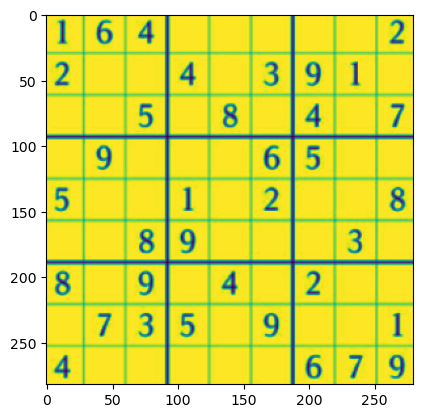

In [23]:

# Basic image processing which include converting into grayscale, blurring, thresholding, etc
# Followed by finding the largest contour from the image and extracting it
# After extracting the sudoku from the image, it was divided into 81 cells

import matplotlib.pyplot as plt

image =cv.imread(r'C:\Users\OJAS\Downloads\sudoku4.png')

def image_preProcessing(image):
    
    img = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    img = cv.bilateralFilter(img, 15, 30, 30)
    img = cv.adaptiveThreshold(img, 255, 1,1,11,2)
    
    contours, hierarchy = cv.findContours(img, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    
    def largest_contour(contours):
        max_area=0
        largest = np.array([])

        for cnt in contours:
            area = cv.contourArea(cnt)

            if area > 50:
                perimeter = cv.arcLength(cnt, True)
                approx = cv.approxPolyDP(cnt, 0.02*perimeter, True)

                if area>max_area and len(approx)==4:
                    max_area=area
                    largest = approx

        return largest, max_area
    
    largestContour, maxArea = largest_contour(contours)
    
    def reorder(vertices):
        vertices = vertices.reshape((4,2))
        new_vertices = np.zeros((4,1,2), dtype=np.uint32)
        add = vertices.sum(1)
        diff = np.diff(vertices, axis=1)
        new_vertices[0] = vertices[np.argmin(add)]
        new_vertices[3] = vertices[np.argmax(add)]
        new_vertices[1] = vertices[np.argmin(diff)]
        new_vertices[2] = vertices[np.argmax(diff)]
        return new_vertices
    
    largestContour = reorder(largestContour)
    
    pts1 = np.float32(largestContour)
    pts2 = np.float32([[0,0],[288,0],[0,288],[288,288]])

    matrix = cv.getPerspectiveTransform(pts1,pts2)
    imagewrap = cv.warpPerspective(image,matrix,(288,288))
    imagewrap =cv.cvtColor(imagewrap, cv.COLOR_BGR2GRAY)
    imagewrap = np.asarray(imagewrap)
    imageFinal = imagewrap[3:imagewrap.shape[0]-3, 4:imagewrap.shape[1]-4]
    plt.imshow(imageFinal)
    
    # Splitting the sudoku into 81 small cells:
    rows = np.vsplit(imagewrap,9)
    cells = []
    for r in rows:
        cols = np.hsplit(r,9)
        for cell in cols:
            cells.append(cell)
    
    return cells

cells = image_preProcessing(image)
        

In [24]:
for i in range(81):
    
    image_float = cells[i].astype(np.float32)

    # Scale the pixel values to increase intensity
    intensity_factor = 0.5  # Increase intensity by a factor of 1.5
    image_scaled = image_float * intensity_factor

    # Clip the pixel values to the valid range [0, 255]
    image_scaled = np.clip(image_scaled, 0, 255)
    
    # Convert the image back to 8-bit unsigned integer representation
    cells[i] = np.array(image_scaled.astype(np.uint8))


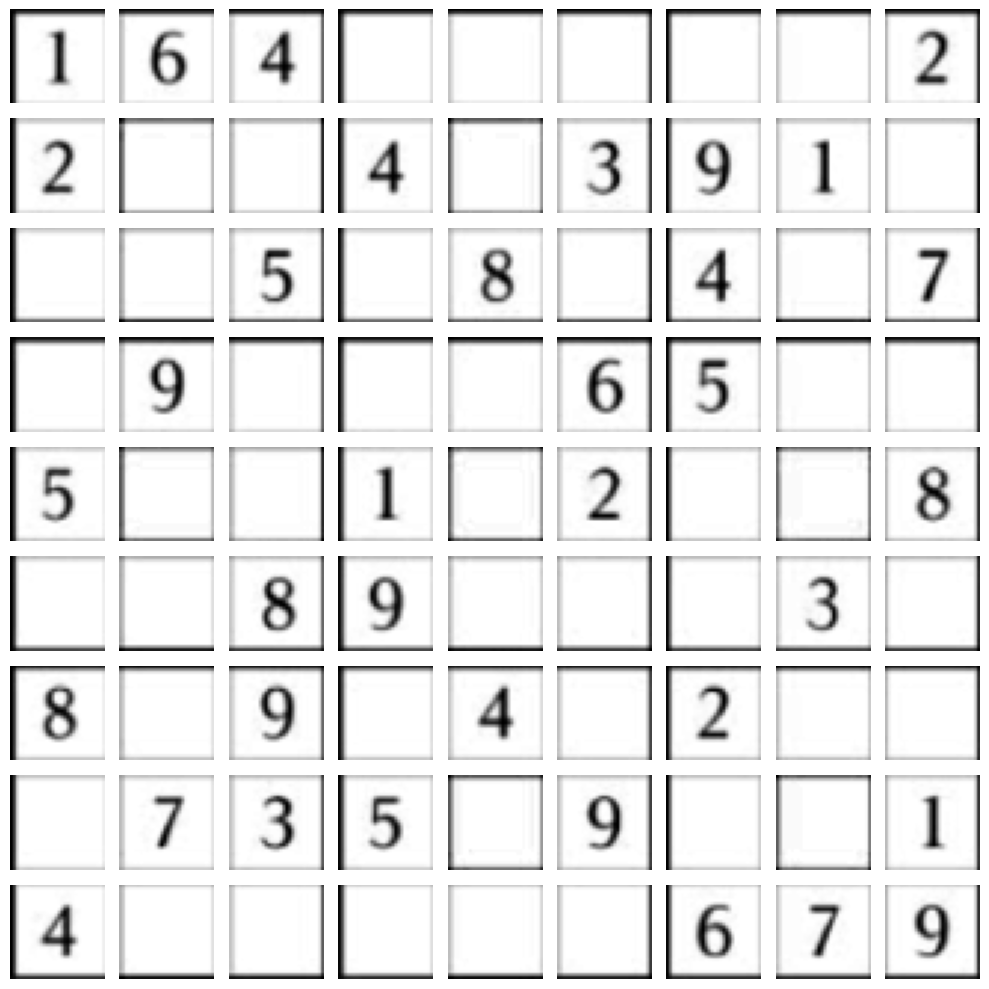

In [25]:
fig, axs = plt.subplots(9, 9, figsize=(10, 10))

for i, ax in enumerate(axs.flat):
    ax.imshow(cells[i], cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()

### Step III : CNN Model for Recognising the digits in the sudoku

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, BatchNormalization, Conv2D, MaxPooling2D

In [8]:
# CNN Model Architecture

model = Sequential()
model.add(Conv2D(60, (5,5), input_shape=(32,32,1), padding='Same', activation='relu'))
model.add(Conv2D(60, (5,5), padding='Same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(60, (5,5), input_shape=(16,16,60), padding='Same', activation='relu'))
model.add(Conv2D(60, (5,5), padding='Same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(100,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 60)        1560      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 60)        90060     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 60)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 60)        90060     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 60)        90060     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 60)         0         
 2D)                                                    

In [9]:
from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop
from sklearn.metrics import accuracy_score, classification_report

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5)

Epoch 1/5
477/477 [==============================] - 100s 208ms/step - loss: 0.8202 - accuracy: 0.8010
Epoch 2/5
477/477 [==============================] - 101s 211ms/step - loss: 0.1313 - accuracy: 0.9594
Epoch 3/5
477/477 [==============================] - 104s 218ms/step - loss: 0.0946 - accuracy: 0.9710
Epoch 4/5
477/477 [==============================] - 109s 228ms/step - loss: 0.0799 - accuracy: 0.9777
Epoch 5/5
477/477 [==============================] - 133s 278ms/step - loss: 0.0783 - accuracy: 0.9772


In [10]:
score = model.evaluate(x_test, y_test)

159/159 [==============================] - 6s 34ms/step - loss: 0.0430 - accuracy: 0.9848


In [26]:
prediction = []

for box in cells:
    image = np.asarray(box)
    image = cv.resize(image, (32,32))
    image = image.reshape(1,32,32,1)
    
    cell_prediction = model.predict(image)
    index = np.argmax(cell_prediction,axis=1)
    pval = np.amax(cell_prediction)
    
    if pval>0.80:
        prediction.append(index[0])
    else:
        prediction.append(0)
        

1/1 [==============================] - 0s 38ms/step


grid = np.reshape(prediction, (9,9))

### Step IV : Backtracking ( Sudoku Solving Algorithm)

In [32]:
N = 9

def printing(arr):
    for i in range(N):
        for j in range(N):
            print(arr[i][j], end = " ")
        print()

def isSafe(grid, row, col, num):

    for x in range(9):
        if grid[row][x] == num:
            return False

    for x in range(9):
        if grid[x][col] == num:
            return False

    startRow = row - row % 3
    startCol = col - col % 3
    for i in range(3):
        for j in range(3):
            if grid[i + startRow][j + startCol] == num:
                return False
    return True

def solveSudoku(grid, row, col):

    if (row == N - 1 and col == N):
        return True
    if col == N:
        row += 1
        col = 0

    if grid[row][col] > 0:
        return solveSudoku(grid, row, col + 1)
    for num in range(1, N + 1, 1):

        if isSafe(grid, row, col, num):

            grid[row][col] = num

            if solveSudoku(grid, row, col + 1):
                return True


        grid[row][col] = 0
    return False


if (solveSudoku(grid, 0, 0)):
    printing(grid)
else:
    print("no solution exists ")

1 6 4 2 9 3 7 5 8 
2 3 7 4 8 5 9 1 6 
9 8 5 1 6 7 4 2 3 
3 9 1 8 7 6 5 4 2 
5 4 6 3 1 2 8 9 7 
8 7 2 9 5 4 3 6 1 
7 1 9 6 4 8 2 3 5 
6 2 8 5 3 9 1 7 4 
4 5 3 7 2 1 6 8 9 
